# CPTox21: Conformal prediction and exchangeability in in vitro toxicological datasets

This notebooks demonstrates the main workflow to obtain the results for the manuscript ...

### Import libraries and modules

In [23]:
import pandas as pd
import numpy as np
import json

In [2]:
from sklearn.svm import SVC
from nonconformist.nc import NcFactory, MarginErrFunc

In [3]:
from cptox21 import (
    define_path, load_signatures_files, StratifiedRatioSampler,CrossValidationSampler,
    KnownIndicesSampler, InductiveConformalPredictor,
    AggregatedConformalPredictor, CPTox21AggregatedConformalPredictor, 
    CPTox21CrossValidator, CPTox21TrainUpdateCrossValidator
)

In [4]:
import logging

logger = logging.getLogger(__name__)
logging.basicConfig(
    filename='test_logger.log',
    filemode='w',
    level=logging.ERROR)

console = logging.StreamHandler()
console.setLevel(logging.INFO) #WARNING)
logging.getLogger('').addHandler(console)

### Define paths and parameters

In [7]:
data_signatures_path = "../data/data_signatures/"
data_statistics_path = "../data/data_statistics/"

In [8]:
endpoint = "NR_ER"

In [9]:
# CP
n_folds_acp = 4  # 10

#### Build ICP classifier

In [10]:
clf = SVC(kernel='rbf', C=50, gamma=0.002, probability=True)
error_function = MarginErrFunc()
normaliser_model = None
nc = NcFactory.create_nc(
    clf, err_func=error_function
)
icp = InductiveConformalPredictor(
        nc_function=nc, condition=(lambda instance: instance[1])
    )  # Mondrian as (default) condition)

#### Build ACP for main framework and for train_update

In [11]:
acp = CPTox21AggregatedConformalPredictor(
        predictor=icp, sampler=StratifiedRatioSampler(n_folds=n_folds_acp),
        aggregation_func=np.median
    )

#### Load data

In [13]:
datasets = ["train", "test", "score"]
train_path = define_path(endpoint=endpoint, data=datasets[0], signatures_path=data_signatures_path)
test_path = define_path(endpoint=endpoint, data=datasets[1], signatures_path=data_signatures_path)
score_path = define_path(endpoint=endpoint, data=datasets[2], signatures_path=data_signatures_path)

X_train, y_train, X_test, y_test, X_score, y_score = load_signatures_files(train_path, test_path, score_path)

# For short runs, uncomment below code for final run
X_train = X_train[:500]
y_train = y_train[:500]

#### Compare size of datasets
To interpret and assess the results, it might be useful to know, how many data points we actually have per dataset, and how balanced they are.

In [14]:
datasets_size_dict = {}
datasets_size_dict["name"] = datasets
datasets_size_dict["actives"] = []
datasets_size_dict["inactives"] = []

for dataset, labels in zip(datasets, [y_train, y_test, y_score]):
    num_actives = np.sum(labels)
    num_inactives = len(labels) - num_actives
    datasets_size_dict["actives"].append(num_actives)
    datasets_size_dict["inactives"].append(num_inactives)
        

pd.DataFrame.from_dict(datasets_size_dict)

,name,actives,inactives
0,train,132.0,368.0
1,test,27.0,231.0
2,score,49.0,441.0


#### Define crossvalidator, which does all acp experiments except for train_update

In [15]:
cross_validator = CPTox21CrossValidator(
            acp, cv_splitter=CrossValidationSampler(),
            score_splitter=StratifiedRatioSampler(test_ratio=0.5)
        )

#### Crossvalidate

In [16]:
cross_validation_dfs = cross_validator.cross_validate(
            steps=10,
            endpoint=endpoint,
            X_train=X_train,
            y_train=y_train,
            X_update=X_test,
            y_update=y_test,
            X_score=X_score,
            y_score=y_score,
        )

len score 245 245


<__array_function__ internals>:5: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.


len score 245 245


<__array_function__ internals>:5: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.


len score 245 245


<__array_function__ internals>:5: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.


len score 245 245


<__array_function__ internals>:5: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.


len score 245 245


<__array_function__ internals>:5: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.


#### Get splits from crossvalidator, so that exactly the same splits can be used for train_update

In [17]:
train_index, test_index = cross_validator.train_indices, cross_validator.test_indices

known_indices_sampler = KnownIndicesSampler(known_train=train_index, known_test=test_index)

#### Define ACP for train_update
Difference to CPTox21AggregatedConformalPredictor: No further updating of the calibration set required for this experiment. Here, we can use a 'typical' ACP.

In [26]:
train_update_acp = AggregatedConformalPredictor(
        predictor=icp, sampler=StratifiedRatioSampler(n_folds=n_folds_acp),
        aggregation_func=np.median
    )

#### Define train_update crossvalidator using same splits as before and crossvalidate

In [27]:
train_update_cross_validator = CPTox21TrainUpdateCrossValidator(
    train_update_acp, cv_splitter=known_indices_sampler
)

train_update_cross_validation_dfs = train_update_cross_validator.cross_validate(steps=10,
                                           endpoint=endpoint,
                                           X_train=X_train,
                                           y_train=y_train,
                                           X_update=X_test,
                                           y_update=y_test,
                                           X_score=X_score,
                                           y_score=y_score,
                                           class_wise_evaluation=False)

[df[["validity", "efficiency", "accuracy", "significance_level"]].head() for df in train_update_cross_validation_dfs]

<__array_function__ internals>:5: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
<__array_function__ internals>:5: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
<__array_function__ internals>:5: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
<__array_function__ internals>:5: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
<__array_function__ internals>:5: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.


[   validity  efficiency  accuracy  significance_level
 0      1.00        0.00     0.000                 0.0
 1      0.94        0.29     0.793                 0.1
 2      0.87        0.60     0.783                 0.2
 3      0.77        0.92     0.750                 0.3
 4      0.62        0.77     0.805                 0.4,
    validity  efficiency  accuracy  significance_level
 0     1.000       0.000     0.000                 0.0
 1     0.949       0.214     0.762                 0.1
 2     0.859       0.467     0.699                 0.2
 3     0.700       0.910     0.670                 0.3
 4     0.543       0.741     0.733                 0.4]

### Plots

#### Calibration plots
For investigating the exchangeability between the datasets, and also to analyse the improvement strategies, calibration plots are useful.

In [28]:
plots = {}

##### Cross-validation
As proof-of-concept, let's look at the calibration plot of the cross-validation. Given the random stratified splitting and sufficient data, the error rate should follow the diagonal line.

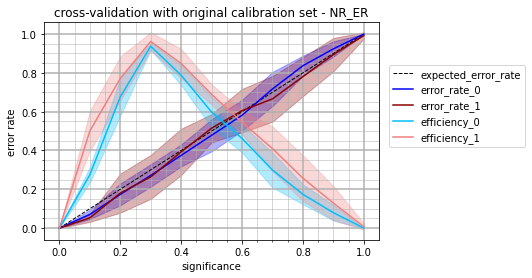

In [29]:
plots["cv"] = cross_validator.calibration_plot( 
    averaged_evaluation_df=cross_validator.averaged_evaluation_df_cv,
            endpoint=endpoint, title_name="cross-validation with original calibration set"
        )

##### Predict score and test set using the aggregated conformal predictor with the 'original' calibration set
If the training set and the predicted data are drawn from the same distribution, and if they are available in sufficient amount, the error rates should follow the diagonal line. Any deviations suggest inexchangeability (or too few data). 

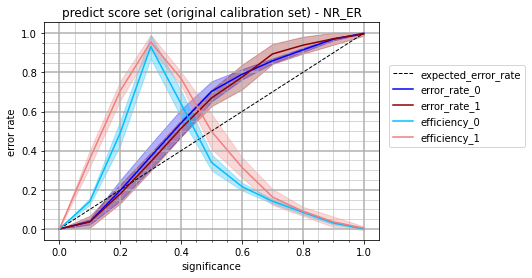

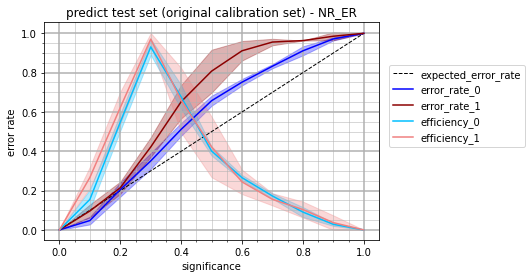

In [30]:
plots["pred_score"] = cross_validator.calibration_plot(
            averaged_evaluation_df=cross_validator.averaged_evaluation_df_pred_score,
            endpoint=endpoint, title_name="predict score set (original calibration set)"
        )
plots["pred_test"] = cross_validator.calibration_plot(
            averaged_evaluation_df=cross_validator.averaged_evaluation_df_pred_test,
            endpoint=endpoint, title_name="predict test set (original calibration set)"
        )

##### Update (increase) the training set with more recent data
Probably the most intuitive way to improve the predictions, will be to update the training set with more recent data. If "old and new" data are available, the can be combined to train a more up-to-date model. The following plots show the cross-validation of this model as well as the prediction of score data. 

For the prediction of the score date, we, usually, do not see a big difference to the above calibration plot, since the number of recent compounds is almost negligible compared to the number of original training compounds. On the other hand, the more recent data would not be enough for training a model on them alone.

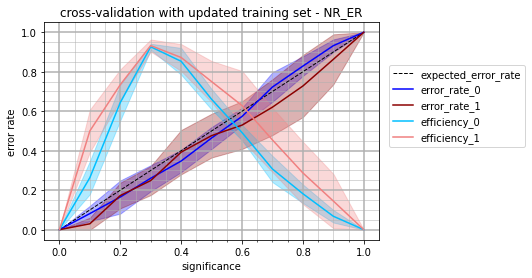

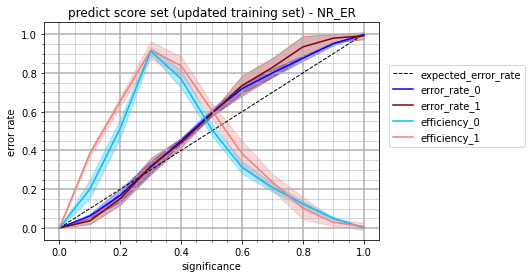

In [31]:
plots["train_update_cv"] = train_update_cross_validator.calibration_plot(
            averaged_evaluation_df=train_update_cross_validator.averaged_evaluation_df_cv,
            endpoint=endpoint, title_name="cross-validation with updated training set"
        )
plots["train_update_pred_score"] = train_update_cross_validator.calibration_plot(
            averaged_evaluation_df=train_update_cross_validator.averaged_evaluation_df_pred_score,
            endpoint=endpoint, title_name="predict score set (updated training set)"
        )

##### Update (exchange) the calibration set with a more recent dataset
If exchangeability between the datasets cannot be assumed, a proposed strategy to improve the applicability of the model, is to update the calibration set with more recent data.
Based on the chronogical release of the Tox21 datasets, we assume that Tox21test is more similar to Tox21 score than Tox21 train. Thus Tox21test is used to update the calibration set.

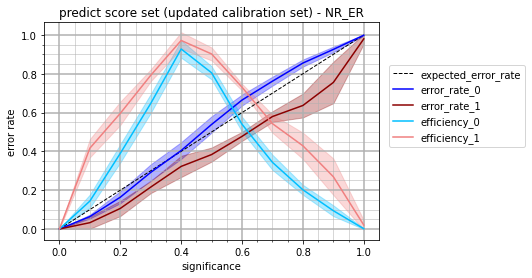

In [32]:
plots["cal_update"] = cross_validator.calibration_plot(
            averaged_evaluation_df=cross_validator.averaged_evaluation_df_pred_cal_update,
            endpoint=endpoint, title_name="predict score set (updated calibration set)"
        )

##### Update (exchange) the calibration set with part of the current prediction set
With the above updating experiment, we made an assumption about the similarity of the datasets. This assumption was not true for all datasets. Thus, a more suitable experiment would be to update the calibration set with part (50%) of the score set and to predict the other part of the score set. This gives us the certainty that the calibration and the prediction set are drawn from the same distribution. Note, that this might be more suitable as a proof of concept, on the other hand it does not represent a real-life scenario.

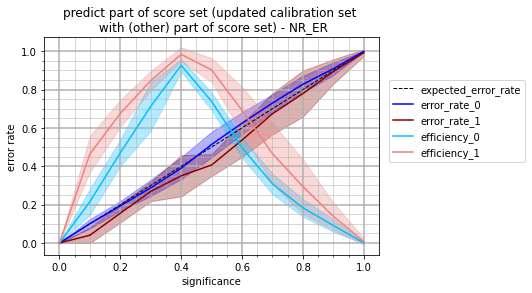

In [33]:
plots["cal_update2"] = cross_validator.calibration_plot(
            averaged_evaluation_df=cross_validator.averaged_evaluation_df_pred_cal_update2,
            endpoint=endpoint, title_name="predict part of score set (updated calibration \
set \n with (other) part of score set)"
        )

#### Plot nonconformity scores
For some endpoints, the above updating strategy (with more recent data/Tox21test) worked very nicely, for others it didn't. Plotting the nonconformity scores for the different datasets (this is done BEFORE calibration) might help to investigate the similarity of the datasets. Are Tox21train and Tox21score really very far from each other while the nonconformity scores Tox21test lie somewhere in between?

<module 'matplotlib.pyplot' from '/home/andrea/anaconda2/envs/cptox21_SI/lib/python3.8/site-packages/matplotlib/pyplot.py'>

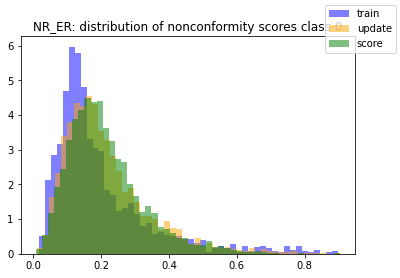

In [34]:
cross_validator.plot_nonconformity_scores(cl=0, endpoint=endpoint)

<module 'matplotlib.pyplot' from '/home/andrea/anaconda2/envs/cptox21_SI/lib/python3.8/site-packages/matplotlib/pyplot.py'>

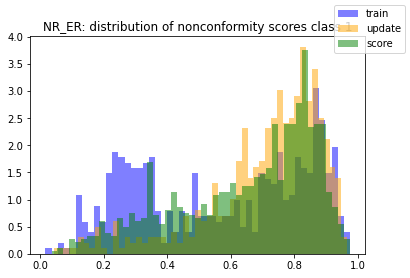

In [35]:
cross_validator.plot_nonconformity_scores(cl=1, endpoint=endpoint)